In [45]:
!pip install pyreadr

You should consider upgrading via the '/anaconda3/bin/python -m pip install --upgrade pip' command.


In [46]:
import os
from pathlib import Path
import pyreadr
import pandas as pd
import numpy as np
from mizani.breaks import date_breaks
from mizani.formatters import date_format
from plotnine import *
from datetime import datetime
import sys
import statsmodels

In [47]:
path = Path(os.getcwd())

In [48]:
base_dir = path.parent.parent

In [49]:
data_in = os.path.join(str(base_dir) , "da_data_repo/case-shiller-la/clean/")
data_out = os.path.join(str(base_dir) , "da_data_repo/ch18-case-shiller-la/")
output = os.path.join(data_out,'output')
func = os.path.join(str(base_dir) ,   "da_case_studies/ch00-tech-prep/")

In [50]:
sys.path.append(func)
from py_helper_functions import *

In [51]:
#rds_path = os.path.join(data_in,"houseprices-data-1990-2018.rds")
#result = pyreadr.read_r(rds_path)

In [52]:
csv_path = os.path.join(data_in,"houseprices-data-1990-2018.csv")
data = pd.read_csv(csv_path)

In [53]:
data.head()

,date,CANA,CANAN,CAUR,CAURN,LXXRNSA,LXXRSA,ps,pn,us,un,emps,empn
0,1990 jan.,12495.2,12329.0,5.2,5.7,100.225510,100.471193,100.471193,100.225510,5.2,5.7,12495.2,12329.0
1,1990 febr.,12500.7,12399.1,5.2,5.6,100.151430,100.761572,100.761572,100.151430,5.2,5.6,12500.7,12399.1
2,1990 márc.,12503.6,12476.7,5.2,5.4,100.017670,100.992838,100.992838,100.017670,5.2,5.4,12503.6,12476.7
3,1990 ápr.,12536.4,12502.9,5.3,5.4,99.986753,100.990410,100.990410,99.986753,5.3,5.4,12536.4,12502.9
4,1990 máj.,12553.2,12566.3,5.4,5.2,99.791606,100.394583,100.394583,99.791606,5.4,5.2,12553.2,12566.3


### Format dates

In [54]:
data[['year', 'month']] = data['date'].str.split(' ', n=1, expand=True)
month_dict = {'jan.':'01',
              'febr.':'02',
              'márc.':'03',
              'ápr.':'04',
              'máj.':'05',
              'jún.':'06',
              'júl.':'07',
              'aug.':'08',
              'szept.':'09',
              'okt.':'10',
              'nov.':'11',
              'dec.':'12'}
data['month1']='-' + data['month'].map(month_dict)
data['date1']=data['year']+data['month1']
data['date']=pd.to_datetime(data['date1'])
data = data.drop(['year','month','month1','date1'],axis=1)

In [55]:
data.dtypes

date       datetime64[ns]
CANA              float64
CANAN             float64
CAUR              float64
CAURN             float64
LXXRNSA           float64
LXXRSA            float64
ps                float64
pn                float64
us                float64
un                float64
emps              float64
empn              float64
dtype: object

In [56]:
data = data[(data['date'] >= '2000-01-01') & (data['date'] < '2018-01-01')]

In [57]:
data = data.sort_values('date')

In [58]:
data.head()

,date,CANA,CANAN,CAUR,CAURN,LXXRNSA,LXXRSA,ps,pn,us,un,emps,empn
120,2000-01-01,14346.8,14132.7,5.0,5.4,100.00000,101.031209,101.031209,100.00000,5.0,5.4,14346.8,14132.7
121,2000-02-01,14390.6,14270.0,5.0,5.4,100.61896,102.043406,102.043406,100.61896,5.0,5.4,14390.6,14270.0
122,2000-03-01,14431.7,14421.3,5.0,5.4,102.12780,103.224699,103.224699,102.12780,5.0,5.4,14431.7,14421.3
123,2000-04-01,14482.4,14451.0,5.1,4.8,103.70410,104.159399,104.159399,103.70410,5.1,4.8,14482.4,14451.0
124,2000-05-01,14550.6,14590.2,5.1,4.8,104.98908,104.924698,104.924698,104.98908,5.1,4.8,14550.6,14590.2


In [59]:
data = data.assign(p=data['pn'],u=data['us'],emp=data['emps'])

In [60]:
data =  data.assign(
        dp = data['p'].diff(),
        p_lag = data['p'].shift(),
        lnp = np.log(data['p']))
data =  data.assign(
        dlnp = data['lnp'].diff(),
        lnp_lag = data['lnp'].shift())
data =  data.assign(
        dlnp_lag = data['dlnp'].shift(),
        du = data['u'].diff(),
        lnemp = np.log(data['emp']))

data['dlnemp'] = data['lnemp'].diff()

In [61]:
data = data.reset_index(drop=True)

In [62]:
data

,date,CANA,CANAN,CAUR,CAURN,LXXRNSA,LXXRSA,ps,pn,us,...,emp,dp,p_lag,lnp,dlnp,lnp_lag,dlnp_lag,du,lnemp,dlnemp
0,2000-01-01,14346.8,14132.7,5.0,5.4,100.000000,101.031209,101.031209,100.000000,5.0,...,14346.8,NaN,NaN,4.605170,NaN,NaN,NaN,NaN,9.571282,NaN
1,2000-02-01,14390.6,14270.0,5.0,5.4,100.618960,102.043406,102.043406,100.618960,5.0,...,14390.6,0.618960,100.000000,4.611341,0.006171,4.605170,NaN,0.0,9.574330,0.003048
2,2000-03-01,14431.7,14421.3,5.0,5.4,102.127800,103.224699,103.224699,102.127800,5.0,...,14431.7,1.508840,100.618960,4.626225,0.014884,4.611341,0.006171,0.0,9.577182,0.002852
3,2000-04-01,14482.4,14451.0,5.1,4.8,103.704100,104.159399,104.159399,103.704100,5.1,...,14482.4,1.576300,102.127800,4.641542,0.015317,4.626225,0.014884,0.1,9.580689,0.003507
4,2000-05-01,14550.6,14590.2,5.1,4.8,104.989080,104.924698,104.924698,104.989080,5.1,...,14550.6,1.284980,103.704100,4.653856,0.012315,4.641542,0.015317,0.0,9.585388,0.004698
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
211,2017-08-01,16880.1,16816.7,4.7,5.0,266.852921,265.270468,265.270468,266.852921,4.7,...,16880.1,0.614863,266.238058,5.586698,0.002307,5.584391,0.010913,0.0,9.733891,0.001464
212,2017-09-01,16910.3,16902.7,4.6,4.4,267.838649,267.011819,267.011819,267.838649,4.6,...,16910.3,0.985727,266.852921,5.590385,0.003687,5.586698,0.002307,-0.1,9.735678,0.001787
213,2017-10-01,16951.3,17054.4,4.5,4.3,268.278285,268.436825,268.436825,268.278285,4.5,...,16951.3,0.439636,267.838649,5.592025,0.001640,5.590385,0.003687,-0.1,9.738100,0.002422
214,2017-11-01,16978.5,17164.8,4.5,4.3,270.010862,271.060084,271.060084,270.010862,4.5,...,16978.5,1.732577,268.278285,5.598462,0.006437,5.592025,0.001640,0.0,9.739703,0.001603


In [63]:
data['trend']=[i for i in range(1,len(data)+1)]

In [64]:
data['month'] = data['date'].dt.strftime('%m').astype('category')

In [65]:
#spot check data same as in R

In [67]:
assert data.loc[0,'p'] == 100
assert data.loc[0,'u'] == 5
assert data.loc[0,'emp'] == 14346.8
np.testing.assert_almost_equal(data.loc[0,'lnemp'], 9.571282,decimal=5)
assert data.loc[0,'month'] == '01'

In [71]:
np.testing.assert_almost_equal(data.loc[215,'p'],271.5796,decimal=5)
np.testing.assert_almost_equal(data.loc[215,'u'],4.4,decimal=5)
np.testing.assert_almost_equal(data.loc[215,'lnemp'],9.742368,decimal=5)
assert data.loc[215,'month'] == '12'

In [20]:
# GRAPHS part 1

In [21]:
limits = datetime(2000, 1, 1), datetime(2018, 1, 1)

In [22]:
breaks = date_breaks('1 year')

In [23]:
price_index_plot = (ggplot(data) 
  + geom_line(aes('date','p'),color = color[1], size = 0.5) 
  + scale_y_continuous(limits = [50,300], breaks = seq(50,300,50)) 
  + scale_x_date(breaks = breaks(limits)[::3], labels = date_format("%b%Y")) 
  + labs(y = "Case-shiller Price index",x= "Date (month)") 
  + theme_bw())

In [24]:
breaks(limits)[::3]

[datetime.datetime(2000, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2003, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2006, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2009, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2012, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2015, 1, 1, 0, 0, tzinfo=datetime.timezone.utc),
 datetime.datetime(2018, 1, 1, 0, 0, tzinfo=datetime.timezone.utc)]

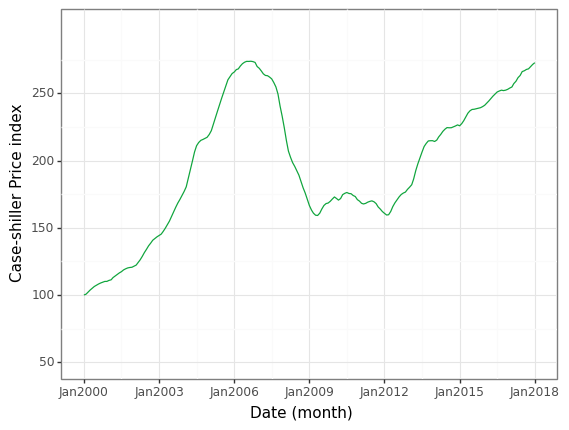

<ggplot: (-9223372036546314713)>

In [25]:
price_index_plot

In [26]:
#GRAPHS part 2

In [27]:
#Create train/holdout data

In [42]:
data_holdout= data.loc[data['date'].dt.year==2017,:]
data_train= data.loc[data['date'].dt.year<2017,:]

In [77]:
#TODO:
#data seems ok but stat values don't match
#R kpss_stat=1.47
#R doc
#unitroot_kpss computes the statistic for the
#Kwiatkowski et al. unit root test with linear trend and lag 1.

statsmodels.tsa.stattools.kpss(data['p'],regression='ct', nlags=1)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value


(1.2007095633957598,
 0.01,
 1,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [79]:
#TODO:
#data seems ok but stat values don't match
#R kpss_stat=1.70
statsmodels.tsa.stattools.kpss(data['lnp'],regression='ct', nlags=1)

/anaconda3/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value


(1.3121946546487138,
 0.01,
 1,
 {'10%': 0.119, '5%': 0.146, '2.5%': 0.176, '1%': 0.216})

In [ ]:
#create arima models in R